# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from xgboost import XGBClassifier, plot_importance
import xgboost as xgb
from util.helper import * 
import util.helper as helpfun
import matplotlib.pyplot as plt
import seaborn as sns

## <span style="color:#ff5f27;"> Prepare training features</span>

In [2]:
# Get current working directory
current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

Current directory: C:\Users\marth\OneDrive - KTH\[Y1] Period 2\ID2223 Scalable Machine Learning and Deep Learning\Projects\Final Pj\ID2223-Final-Project


In [3]:
# Construct path
data_path = os.path.join(current_dir, 'util', 'data', 'feature_eng_stats.csv')
training_df = pd.read_csv(data_path)
#print(training_df)

In [4]:
#check_dataframe_types(training_df)

In [5]:
#Check float Value vs NaN
column_check = ['champion']

for col in column_check:
    check_nan_float(training_df, col)

Are all float values NaN? True
Number of float values: 43
Number of NaN values: 43


In [6]:
# Remove rows where champion is NaN
training_df = training_df.dropna(subset=['champion'])

# Verify no more NaN in champion column
print(f"\nRemaining NaN in champion column: {training_df['champion'].isna().sum()}")


Remaining NaN in champion column: 0


In [7]:
#Clean table and convert string to num, remove future stats
training_df = convert_training_df(training_df)
#print(training_df)

In [8]:
def calculate_champ_variety_score(df):
    df = df.copy()  # Create a copy to avoid warnings
    
    # Create a list of champion columns we want to check
    champ_columns = [
        'most_champ_1', 'most_champ_2', 'most_champ_3',
        '7d_champ_1', '7d_champ_2', '7d_champ_3'
    ]
    
    # Filter to only include columns that exist in the DataFrame
    existing_columns = [col for col in champ_columns if col in df.columns]
    
    # Function to count unique non-NaN values
    def count_unique_champions(row):
        # Get all values that are not NaN
        valid_champions = row[existing_columns].dropna()
        # Count unique values
        return len(set(valid_champions))
    
    # Calculate the score for each row
    df['champ_variety_score'] = df.apply(count_unique_champions, axis=1)
    
    return df

In [9]:
def calculate_playstyle(df):
    df = df.copy()
    
    # Playstyle categorization (0-5)
    conditions = [
        # 0: Assassin/Carry (high kills, high KDA, high kill participation)
        (df['avg_kills'] > df['avg_assists']) & 
        (df['kda_ratio_profile'] > 3) & 
        (df['kill_participation_profile'] > 0.6),
        
        # 1: Support/Utility (high assists, good KDA, high kill participation)
        (df['avg_assists'] > df['avg_kills']) & 
        (df['kda_ratio_profile'] > 2.5) & 
        (df['kill_participation_profile'] > 0.55),
        
        # 2: Tank/Initiator (moderate deaths, high assists, high kill participation)
        (df['avg_deaths'] > 3) & 
        (df['avg_assists'] > df['avg_kills']) & 
        (df['kill_participation_profile'] > 0.5),
        
        # 3: Split-pusher (lower kill participation, good KDA)
        (df['kill_participation_profile'] < 0.5) & 
        (df['kda_ratio_profile'] > 2),
        
        # 4: Aggressive/Fighter (high kills and deaths, high kill participation)
        (df['avg_kills'] > 3) & 
        (df['avg_deaths'] > 4) & 
        (df['kill_participation_profile'] > 0.55)
    ]
    
    values = [0, 1, 2, 3, 4]  # Numeric values for each playstyle
    df['playstyle'] = np.select(conditions, values, default=5)
    
    return df

In [10]:
training_df = calculate_champ_variety_score(training_df)

In [11]:
training_df = calculate_playstyle(training_df)

In [12]:
# Add top 20 highest score features
top_champ_scores = training_df.apply(get_top_champion_scores, n=5, axis=1) #champion variety 5
training_df = pd.concat([training_df, top_champ_scores], axis=1)
print(training_df)

       champion  region          date  team  avg_tier  team_champ1  \
0           130       1  1.736014e+09     2         1           40   
1            19       1  1.736012e+09     1         2          111   
2            37       1  1.736010e+09     1         2           42   
3           125       1  1.736009e+09     1         2            6   
4            96       1  1.735932e+09     2         2           80   
...         ...     ...           ...   ...       ...          ...   
10326       129       2  1.734516e+09     2         2           29   
10327       159       2  1.734514e+09     2         2          124   
10328       160       2  1.734437e+09     2         1           52   
10329       160       2  1.734338e+09     2         3          110   
10330        71       2  1.734178e+09     2         1           78   

       team_champ2  team_champ3  team_champ4  opp_champ1  ...  1_champ_score  \
0               71           33          106         129  ...       0.843490   

In [13]:
# List of columns to remove
date = ['date']
recent_stats = ['total_games', 'wins', 'losses', 'win_rate', 'avg_kills', 'avg_deaths', 'avg_assists', 'kda_ratio_profile', 'kill_participation_profile']
recent_champs = ['most_champ_1', 'most_champ_2']
recent_champs_2 = ['most_champ_3']
recent_champs_stats = ['WR_1', 'W_1', 'L_1', 'KDA_1','WR_2', 'W_2', 'L_2', 'KDA_2', 'WR_3', 'W_3', 'L_3', 'KDA_3']
preferred_roles = ['TOP', 'JUNGLE', 'MID', 'ADC', 'SUPPORT']  
most_roles = ['most_role_1', 'most_role_2']
most_roles_value= ['most_role_1_value', 'most_role_2_value']
season_champ_top3 = ['season_champ_1', 'season_champ_2''season_champ_3']
season_stats = [ 'cs_ssn_1', 'cpm_ssn_1', 'kda_ssn_1', 
    'k_ssn_1', 'd_ssn_1', 'a_ssn_1', 'wr_ssn_1', 'games_ssn_1',  'cs_ssn_2', 
    'cpm_ssn_2', 'kda_ssn_2', 'k_ssn_2', 'd_ssn_2', 'a_ssn_2', 'wr_ssn_2', 'games_ssn_2', 
     'cs_ssn_3', 'cpm_ssn_3', 'kda_ssn_3', 'k_ssn_3', 'd_ssn_3', 'a_ssn_3', 
    'wr_ssn_3', 'games_ssn_3', 'season_champ_4', 'cs_ssn_4', 'cpm_ssn_4', 'kda_ssn_4', 'k_ssn_4', 
    'd_ssn_4', 'a_ssn_4', 'wr_ssn_4', 'games_ssn_4', 'season_champ_5', 'cs_ssn_5', 'cpm_ssn_5', 
    'kda_ssn_5', 'k_ssn_5', 'd_ssn_5', 'a_ssn_5', 'wr_ssn_5', 'games_ssn_5', 'season_champ_6', 
    'cs_ssn_6', 'cpm_ssn_6', 'kda_ssn_6', 'k_ssn_6', 'd_ssn_6', 'a_ssn_6', 'wr_ssn_6', 'games_ssn_6', 
    'season_champ_7', 'cs_ssn_7', 'cpm_ssn_7', 'kda_ssn_7', 'k_ssn_7', 'd_ssn_7', 'a_ssn_7', 
    'wr_ssn_7', 'games_ssn_7']
weekly_stats_1=['7d_champ_1', '7d_total_1',  '7d_WR_1', '7d_champ_2', '7d_total_2',  '7d_WR_2', '7d_champ_3', '7d_total_3', '7d_WR_3']
weekly_stats_2=['7d_W_1', '7d_L_1', '7d_W_2', '7d_L_2','7d_W_3', '7d_L_3']
mastery_stats=['mastery_champ_1', 'm_lv_1', 'mastery_champ_2', 'm_lv_2', 
    'mastery_champ_3', 'm_lv_3', 'mastery_champ_4', 'm_lv_4', 'mastery_champ_5', 'm_lv_5', 
    'mastery_champ_6', 'm_lv_6', 'mastery_champ_7', 'm_lv_7', 'mastery_champ_8', 'm_lv_8', 
    'mastery_champ_9', 'm_lv_9', 'mastery_champ_10', 'm_lv_10', 'mastery_champ_11', 'm_lv_11', 
    'mastery_champ_12', 'm_lv_12', 'mastery_champ_13', 'm_lv_13', 'mastery_champ_14', 'm_lv_14', 
    'mastery_champ_15', 'm_lv_15', 'mastery_champ_16', 'm_lv_16']
champions = [
            "Aatrox", "Ahri", "Akali", "Akshan", "Alistar", "Ambessa", "Amumu", "Anivia", "Annie", "Aphelios", "Ashe", "Aurelion Sol",
            "Aurora", "Azir", "Bard", "Bel'Veth", "Blitzcrank", "Brand", "Braum", "Briar", "Caitlyn", "Camille", "Cassiopeia", "Cho'Gath",
            "Corki", "Darius", "Diana", "Dr. Mundo", "Draven", "Ekko", "Elise", "Evelynn", "Ezreal", "Fiddlesticks", "Fiora", "Fizz", "Galio",
            "Gangplank", "Garen", "Gnar", "Gragas", "Graves", "Gwen", "Hecarim", "Heimerdinger", "Hwei", "Illaoi", "Irelia", "Ivern", "Janna",
            "Jarvan IV", "Jax", "Jayce", "Jhin", "Jinx", "K'Sante", "Kai'Sa", "Kalista", "Karma", "Karthus", "Kassadin", "Katarina", "Kayle",
            "Kayn", "Kennen", "Kha'Zix", "Kindred", "Kled", "Kog'Maw", "LeBlanc", "Lee Sin", "Leona", "Lillia", "Lissandra", "Lucian", "Lulu",
            "Lux", "Malphite", "Malzahar", "Maokai", "Master Yi", "Milio", "Miss Fortune", "Mordekaiser", "Morgana", "Naafiri", "Nami", "Nasus",
            "Nautilus", "Neeko", "Nidalee", "Nilah", "Nocturne", "Nunu & Willump", "Olaf", "Orianna", "Ornn", "Pantheon", "Poppy", "Pyke",
            "Qiyana", "Quinn", "Rakan", "Rammus", "Rek'Sai", "Rell", "Renata Glasc", "Renekton", "Rengar", "Riven", "Rumble", "Ryze", "Samira",
            "Sejuani", "Senna", "Seraphine", "Sett", "Shaco", "Shen", "Shyvana", "Singed", "Sion", "Sivir", "Skarner", "Smolder", "Sona",
            "Soraka", "Swain", "Sylas", "Syndra", "Tahm Kench", "Taliyah", "Talon", "Taric", "Teemo", "Thresh", "Tristana", "Trundle",
            "Tryndamere", "Twisted Fate", "Twitch", "Udyr", "Urgot", "Varus", "Vayne", "Veigar", "Vel'Koz", "Vex", "Vi", "Viego", "Viktor",
            "Vladimir", "Volibear", "Warwick", "Wukong", "Xayah", "Xerath", "Xin Zhao", "Yasuo", "Yone", "Yorick", "Yuumi", "Zac", "Zed",
            "Zeri", "Ziggs", "Zilean", "Zoe", "Zyra"
        ]
champion_score = ['1_champ_score', '2_champ_score', '3_champ_score', '4_champ_score', '5_champ_score']
# Combine all columns to remove into a single list
columns_to_remove = []

# Include categories conditionally
columns_to_remove += date
columns_to_remove += recent_stats
#columns_to_remove += recent_champs
columns_to_remove += recent_champs_2
columns_to_remove += recent_champs_stats
columns_to_remove += preferred_roles
columns_to_remove += most_roles
#columns_to_remove += most_roles_value
#columns_to_remove += season_champ_top3
columns_to_remove += season_stats
columns_to_remove += weekly_stats_1
columns_to_remove += weekly_stats_2
columns_to_remove += mastery_stats
columns_to_remove += champions
columns_to_remove += champion_score

# Drop the specified columns
training_df = training_df.drop(columns=columns_to_remove)

# Display the resulting DataFrame
print(training_df)

       champion  region  team  avg_tier  team_champ1  team_champ2  \
0           130       1     2         1           40           71   
1            19       1     1         2          111           71   
2            37       1     1         2           42           48   
3           125       1     1         2            6           91   
4            96       1     2         2           80           93   
...         ...     ...   ...       ...          ...          ...   
10326       129       2     2         2           29          138   
10327       159       2     2         2          124            2   
10328       160       2     2         1           52          124   
10329       160       2     2         3          110           67   
10330        71       2     2         1           78           46   

       team_champ3  team_champ4  opp_champ1  opp_champ2  ...  season_champ_1  \
0               33          106         129         150  ...           129.0   
1          

## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

In [14]:
#training df reset for debug purpose
current_dir = os.getcwd()

# Construct path
data_path = os.path.join(current_dir, 'util', 'data', 'feature_eng_stats.csv')
training_df = pd.read_csv(data_path)

training_df = training_df.dropna(subset=['champion'])

#Clean table and convert string to num, remove future stats
training_df = convert_training_df(training_df)

training_df = calculate_champ_variety_score(training_df)

training_df = calculate_playstyle(training_df)

# Add top 3 highest score features
top_champ_scores = training_df.apply(get_top_champion_scores, n=5, axis=1) #champion variety 5
training_df = pd.concat([training_df, top_champ_scores], axis=1)

# List of columns to remove
date = ['date']
recent_stats = ['total_games', 'wins', 'losses', 'win_rate', 'avg_kills', 'avg_deaths', 'avg_assists', 'kda_ratio_profile', 'kill_participation_profile']
recent_champs = ['most_champ_1', 'most_champ_2']
recent_champs_2 = ['most_champ_3']
recent_champs_stats = ['WR_1', 'W_1', 'L_1', 'KDA_1','WR_2', 'W_2', 'L_2', 'KDA_2', 'WR_3', 'W_3', 'L_3', 'KDA_3']
preferred_roles = ['TOP', 'JUNGLE', 'MID', 'ADC', 'SUPPORT']  
most_roles = ['most_role_1', 'most_role_2']
most_roles_value= ['most_role_1_value', 'most_role_2_value']
season_champ_top3 = ['season_champ_1', 'season_champ_2''season_champ_3']
season_stats = [ 'cs_ssn_1', 'cpm_ssn_1', 'kda_ssn_1', 
    'k_ssn_1', 'd_ssn_1', 'a_ssn_1', 'wr_ssn_1', 'games_ssn_1',  'cs_ssn_2', 
    'cpm_ssn_2', 'kda_ssn_2', 'k_ssn_2', 'd_ssn_2', 'a_ssn_2', 'wr_ssn_2', 'games_ssn_2', 
     'cs_ssn_3', 'cpm_ssn_3', 'kda_ssn_3', 'k_ssn_3', 'd_ssn_3', 'a_ssn_3', 
    'wr_ssn_3', 'games_ssn_3', 'season_champ_4', 'cs_ssn_4', 'cpm_ssn_4', 'kda_ssn_4', 'k_ssn_4', 
    'd_ssn_4', 'a_ssn_4', 'wr_ssn_4', 'games_ssn_4', 'season_champ_5', 'cs_ssn_5', 'cpm_ssn_5', 
    'kda_ssn_5', 'k_ssn_5', 'd_ssn_5', 'a_ssn_5', 'wr_ssn_5', 'games_ssn_5', 'season_champ_6', 
    'cs_ssn_6', 'cpm_ssn_6', 'kda_ssn_6', 'k_ssn_6', 'd_ssn_6', 'a_ssn_6', 'wr_ssn_6', 'games_ssn_6', 
    'season_champ_7', 'cs_ssn_7', 'cpm_ssn_7', 'kda_ssn_7', 'k_ssn_7', 'd_ssn_7', 'a_ssn_7', 
    'wr_ssn_7', 'games_ssn_7']
weekly_stats_1=['7d_champ_1', '7d_total_1',  '7d_WR_1', '7d_champ_2', '7d_total_2',  '7d_WR_2', '7d_champ_3', '7d_total_3', '7d_WR_3']
weekly_stats_2=['7d_W_1', '7d_L_1', '7d_W_2', '7d_L_2','7d_W_3', '7d_L_3']
mastery_stats=['mastery_champ_1', 'm_lv_1', 'mastery_champ_2', 'm_lv_2', 
    'mastery_champ_3', 'm_lv_3', 'mastery_champ_4', 'm_lv_4', 'mastery_champ_5', 'm_lv_5', 
    'mastery_champ_6', 'm_lv_6', 'mastery_champ_7', 'm_lv_7', 'mastery_champ_8', 'm_lv_8', 
    'mastery_champ_9', 'm_lv_9', 'mastery_champ_10', 'm_lv_10', 'mastery_champ_11', 'm_lv_11', 
    'mastery_champ_12', 'm_lv_12', 'mastery_champ_13', 'm_lv_13', 'mastery_champ_14', 'm_lv_14', 
    'mastery_champ_15', 'm_lv_15', 'mastery_champ_16', 'm_lv_16']
champions = [
            "Aatrox", "Ahri", "Akali", "Akshan", "Alistar", "Ambessa", "Amumu", "Anivia", "Annie", "Aphelios", "Ashe", "Aurelion Sol",
            "Aurora", "Azir", "Bard", "Bel'Veth", "Blitzcrank", "Brand", "Braum", "Briar", "Caitlyn", "Camille", "Cassiopeia", "Cho'Gath",
            "Corki", "Darius", "Diana", "Dr. Mundo", "Draven", "Ekko", "Elise", "Evelynn", "Ezreal", "Fiddlesticks", "Fiora", "Fizz", "Galio",
            "Gangplank", "Garen", "Gnar", "Gragas", "Graves", "Gwen", "Hecarim", "Heimerdinger", "Hwei", "Illaoi", "Irelia", "Ivern", "Janna",
            "Jarvan IV", "Jax", "Jayce", "Jhin", "Jinx", "K'Sante", "Kai'Sa", "Kalista", "Karma", "Karthus", "Kassadin", "Katarina", "Kayle",
            "Kayn", "Kennen", "Kha'Zix", "Kindred", "Kled", "Kog'Maw", "LeBlanc", "Lee Sin", "Leona", "Lillia", "Lissandra", "Lucian", "Lulu",
            "Lux", "Malphite", "Malzahar", "Maokai", "Master Yi", "Milio", "Miss Fortune", "Mordekaiser", "Morgana", "Naafiri", "Nami", "Nasus",
            "Nautilus", "Neeko", "Nidalee", "Nilah", "Nocturne", "Nunu & Willump", "Olaf", "Orianna", "Ornn", "Pantheon", "Poppy", "Pyke",
            "Qiyana", "Quinn", "Rakan", "Rammus", "Rek'Sai", "Rell", "Renata Glasc", "Renekton", "Rengar", "Riven", "Rumble", "Ryze", "Samira",
            "Sejuani", "Senna", "Seraphine", "Sett", "Shaco", "Shen", "Shyvana", "Singed", "Sion", "Sivir", "Skarner", "Smolder", "Sona",
            "Soraka", "Swain", "Sylas", "Syndra", "Tahm Kench", "Taliyah", "Talon", "Taric", "Teemo", "Thresh", "Tristana", "Trundle",
            "Tryndamere", "Twisted Fate", "Twitch", "Udyr", "Urgot", "Varus", "Vayne", "Veigar", "Vel'Koz", "Vex", "Vi", "Viego", "Viktor",
            "Vladimir", "Volibear", "Warwick", "Wukong", "Xayah", "Xerath", "Xin Zhao", "Yasuo", "Yone", "Yorick", "Yuumi", "Zac", "Zed",
            "Zeri", "Ziggs", "Zilean", "Zoe", "Zyra"
        ]
champion_score = ['1_champ_score', '2_champ_score', '3_champ_score', '4_champ_score', '5_champ_score']
# Combine all columns to remove into a single list
columns_to_remove = []

# Include categories conditionally
columns_to_remove += date
columns_to_remove += recent_stats
#columns_to_remove += recent_champs
columns_to_remove += recent_champs_2
columns_to_remove += recent_champs_stats
columns_to_remove += preferred_roles
columns_to_remove += most_roles
#columns_to_remove += most_roles_value
#columns_to_remove += season_champ_top3
columns_to_remove += season_stats
columns_to_remove += weekly_stats_1
columns_to_remove += weekly_stats_2
columns_to_remove += mastery_stats
columns_to_remove += champions
columns_to_remove += champion_score

# Drop the specified columns
training_df = training_df.drop(columns=columns_to_remove)

# Display the resulting DataFrame
print(training_df)

       champion  region  team  avg_tier  team_champ1  team_champ2  \
0           130       1     2         1           40           71   
1            19       1     1         2          111           71   
2            37       1     1         2           42           48   
3           125       1     1         2            6           91   
4            96       1     2         2           80           93   
...         ...     ...   ...       ...          ...          ...   
10326       129       2     2         2           29          138   
10327       159       2     2         2          124            2   
10328       160       2     2         1           52          124   
10329       160       2     2         3          110           67   
10330        71       2     2         1           78           46   

       team_champ3  team_champ4  opp_champ1  opp_champ2  ...  season_champ_1  \
0               33          106         129         150  ...           129.0   
1          

In [15]:
# Check data types
def check_datatypes(df):
    return pd.DataFrame({
        'dtype': df.dtypes,
        'unique_values': df.nunique()
    })

dtype_info = check_datatypes(training_df)
print("Feature data types:")
print(dtype_info)

print("\nChampion Variety Score Distribution (Percentages):")
percent_dist = (training_df['champ_variety_score'].value_counts(normalize=True) * 100).sort_index(ascending=False)
for score, percentage in percent_dist.items():
    print(f"Score {score}: {percentage:.2f}%")

Feature data types:
                       dtype  unique_values
champion               int64            165
region                 int64              4
team                   int64              2
avg_tier               int64              3
team_champ1            int64            142
team_champ2            int64            148
team_champ3            int64            139
team_champ4            int64            132
opp_champ1             int64            139
opp_champ2             int64             76
opp_champ3             int64            137
opp_champ4             int64            111
opp_champ5             int64             93
most_champ_1           int64            125
most_champ_2         float64            116
most_role_1_value    float64             15
most_role_2_value    float64             11
season_champ_1       float64            117
season_champ_2       float64            117
season_champ_3       float64            118
champ_variety_score    int64              6
playstyle   

In [16]:
# Prepare train features
X = training_df.drop('champion', axis=1, errors='ignore')
y = training_df['champion']

In [17]:
##Remove rows with target group fewer than threshold 

threshold = 10

# Create a composite stratification label by combining 'region' and 'champion'
X['stratify_label'] = X['region'].astype(str) + '_' + y.astype(str)

# Count the instances of each stratification label
stratify_counts = X['stratify_label'].value_counts()

# Identify stratification labels with fewer than two instances
few_instance_stratify_labels = stratify_counts[stratify_counts < threshold].index

# Remove rows with stratification labels that have fewer than two instances
mask = ~X['stratify_label'].isin(few_instance_stratify_labels)
X_filtered = X[mask].copy()
y_filtered = y[mask].copy()

In [18]:
# Get the counts of each unique value in y_filtered
unique_counts = y.value_counts()

# Define the maximum threshold
max_threshold = 11

# Filter the counts to include only those less than the maximum threshold
filtered_counts = unique_counts[unique_counts < max_threshold]

# Calculate the total number of champions that meet the criteria
total_champions = len(filtered_counts)

# Display the result
print(f"Total number of champions with occurrences less than {max_threshold}: {total_champions}")

Total number of champions with occurrences less than 11: 28


In [19]:
# Encode the target values to start from 0
label_encoder = LabelEncoder()
y_filtered_encoded = label_encoder.fit_transform(y_filtered)

In [20]:
# First split: training and temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_filtered, 
    y_filtered_encoded,
    test_size=0.2,  # 60% for training
    random_state=42,
    stratify=X_filtered['stratify_label']  # Stratify by the composite label
)

In [21]:
# Drop the composite stratification label after usage
X_train = X_train.drop(columns=['stratify_label'])
X_temp = X_temp.drop(columns=['stratify_label'])

In [22]:
# Second split: validation and test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,  # Split remaining 40% into two equal parts
    random_state=42,
    stratify=X_temp['region']  # Stratify by the composite label
)

In [23]:
# Print split information
print("\nSplit Summary:")
print(f"Training set:      {X_train.shape} ({len(X_train)/len(X):.1%})")
print(f"Validation set:    {X_val.shape} ({len(X_val)/len(X):.1%})")
print(f"Test set:         {X_test.shape} ({len(X_test)/len(X):.1%})")

# Check region distribution in each split
print("\nRegion Distribution in Splits:")
print("\nTraining Set:")
print(X_train['region'].value_counts(normalize=True))
print("\nValidation Set:")
print(X_val['region'].value_counts(normalize=True))
print("\nTest Set:")
print(X_test['region'].value_counts(normalize=True))

# Quick champion distribution check (optional)
print("\nChampion counts in each split:")
print(f"Training set unique champions: {np.unique(y_train).size}")
print(f"Validation set unique champions: {np.unique(y_val).size}")
print(f"Test set unique champions: {np.unique(y_test).size}")


Split Summary:
Training set:      (7457, 26) (72.5%)
Validation set:    (932, 26) (9.1%)
Test set:         (933, 26) (9.1%)

Region Distribution in Splits:

Training Set:
region
2    0.570337
1    0.288722
3    0.071342
4    0.069599
Name: proportion, dtype: float64

Validation Set:
region
2    0.571888
1    0.286481
3    0.071888
4    0.069742
Name: proportion, dtype: float64

Test Set:
region
2    0.571275
1    0.286174
3    0.071811
4    0.070740
Name: proportion, dtype: float64

Champion counts in each split:
Training set unique champions: 131
Validation set unique champions: 129
Test set unique champions: 127


In [24]:
for i, col in enumerate(X_train.columns):
    print(f"{i}: {col}")

0: region
1: team
2: avg_tier
3: team_champ1
4: team_champ2
5: team_champ3
6: team_champ4
7: opp_champ1
8: opp_champ2
9: opp_champ3
10: opp_champ4
11: opp_champ5
12: most_champ_1
13: most_champ_2
14: most_role_1_value
15: most_role_2_value
16: season_champ_1
17: season_champ_2
18: season_champ_3
19: champ_variety_score
20: playstyle
21: 1_champ_name
22: 2_champ_name
23: 3_champ_name
24: 4_champ_name
25: 5_champ_name


In [25]:
y_train

array([ 62,  98, 129, ...,  65,  62,  42], dtype=int64)

In [26]:
def analyze_champion_distribution(y_data, label_encoder):
    """
    Analyze champion distribution in the dataset
    """
    # Convert encoded labels back to champion names
    champion_names = label_encoder.inverse_transform(y_data)
    dist = pd.Series(champion_names).value_counts()
    
    print(f"\nChampion Distribution Analysis:")
    print(f"Total unique champions: {len(dist)}")
    print(f"Samples per champion:")
    print(f"  Min: {dist.min()}")
    print(f"  Max: {dist.max()}")
    print(f"  Mean: {dist.mean():.2f}")
    print(f"Champions with fewer than {threshold} samples: {len(dist[dist < threshold])}")
    
    return dist

def create_balanced_batches(X_data, y_data, batch_size=512):
    """
    Create balanced batches for training
    """
    champion_counts = Counter(y_data)
    champions = list(champion_counts.keys())
    
    # Create indices for each champion
    champion_indices = {
        champ: np.where(y_data == champ)[0]
        for champ in champions
    }
    
    # Shuffle indices
    for indices in champion_indices.values():
        np.random.shuffle(indices)
    
    # Calculate minimum samples per champion
    min_samples_per_champion = max(1, batch_size // len(champions))
    
    batches = []
    positions = {champ: 0 for champ in champions}
    
    while True:
        batch_indices = []
        
        # Add samples from each champion
        for champ in champions:
            indices = champion_indices[champ]
            pos = positions[champ]
            
            # Reset if needed
            if pos >= len(indices):
                np.random.shuffle(indices)
                positions[champ] = 0
                pos = 0
            
            # Add samples
            samples_to_add = min(min_samples_per_champion, len(indices) - pos)
            if samples_to_add > 0:
                batch_indices.extend(indices[pos:pos + samples_to_add])
                positions[champ] = pos + samples_to_add
        
        if len(batch_indices) > 0:
            batches.append(batch_indices)
        
        # Check if we've covered the dataset
        if all(positions[champ] >= len(champion_indices[champ]) for champ in champions):
            break
    
    return batches

In [27]:
initial_dist = analyze_champion_distribution(y_train, label_encoder)


Champion Distribution Analysis:
Total unique champions: 131
Samples per champion:
  Min: 8
  Max: 258
  Mean: 56.92
Champions with fewer than 10 samples: 7


---

## <span style="color:#ff5f27;">🧬 Modeling</span>

Pick XGBClassifier in champion prediction since it is a categorical variable

In [28]:
xgb_classifier = XGBClassifier(
    max_depth=4,                # Reduced from 6
    learning_rate=0.001,         # Reduced from 0.05
    n_estimators=1000,          # Set to observe behavior around plateau point
    subsample=0.7,             # Reduced from 0.8
    colsample_bytree=0.7,      # Reduced from 0.8
    min_child_weight=5,        # Increased from 3
    reg_alpha=0.5,             # Increased from 0.1
    reg_lambda=1.5,            # Increased from 1.0
    gamma=0.2,                 # Increased from 0.1
    objective='multi:softmax',
    tree_method='hist',
    enable_categorical=True,
    early_stopping_rounds=20,   # Added early stopping
    eval_metric=['merror', 'mlogloss'],
    eval_metric_ops='merror',
    random_state=42
)


In [29]:
# Create balanced dataset using the batch creation function
def create_balanced_dataset(X, y):
    """
    Create a balanced dataset for training
    """
    champion_counts = Counter(y)
    all_champions = list(champion_counts.keys())
    
    # Create indices for each champion
    champion_indices = {
        champ: np.where(y == champ)[0]
        for champ in all_champions
    }
    
    # Calculate the desired number of samples per champion
    max_samples_per_champion = max(champion_counts.values())
    
    balanced_indices = []
    for champ, indices in champion_indices.items():
        # Resample if needed
        if len(indices) < max_samples_per_champion:
            resampled_indices = np.random.choice(
                indices, 
                size=max_samples_per_champion, 
                replace=True
            )
            balanced_indices.extend(resampled_indices)
        else:
            balanced_indices.extend(indices[:max_samples_per_champion])
    
    return X.iloc[balanced_indices], y[balanced_indices]

In [30]:
X_train_balanced, y_train_balanced = create_balanced_dataset(X_train, y_train)

In [31]:
xgb_classifier.fit(
    X_train_balanced, 
    y_train_balanced,
    eval_set=[(X_train_balanced, y_train_balanced), (X_val, y_val)],
    verbose=100  # Print progress every 100 rounds
)

C:\Users\marth\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "eval_metric_ops" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-merror:0.67818	validation_0-mlogloss:4.86719	validation_1-merror:0.79828	validation_1-mlogloss:4.87023
[100]	validation_0-merror:0.45979	validation_0-mlogloss:4.19169	validation_1-merror:0.62768	validation_1-mlogloss:4.43920
[200]	validation_0-merror:0.42825	validation_0-mlogloss:3.75486	validation_1-merror:0.61159	validation_1-mlogloss:4.15721
[300]	validation_0-merror:0.40038	validation_0-mlogloss:3.43824	validation_1-merror:0.59657	validation_1-mlogloss:3.95073
[400]	validation_0-merror:0.38508	validation_0-mlogloss:3.18824	validation_1-merror:0.59335	validation_1-mlogloss:3.79065
[500]	validation_0-merror:0.37212	validation_0-mlogloss:2.98158	validation_1-merror:0.59120	validation_1-mlogloss:3.66079
[600]	validation_0-merror:0.36141	validation_0-mlogloss:2.80562	validation_1-merror:0.59013	validation_1-mlogloss:3.55242
[700]	validation_0-merror:0.34967	validation_0-mlogloss:2.65283	validation_1-merror:0.59013	validation_1-mlogloss:3.45936
[800]	validation_0-merror:

C:\Users\marth\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=20,
              enable_categorical=True, eval_metric=['merror', 'mlogloss'],
              eval_metric_ops='merror', feature_types=None, gamma=0.2,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, ...)

In [35]:
# Get the best iteration from early stopping
best_iteration = xgb_classifier.best_iteration
print(f"\nBest iteration: {best_iteration}")


Best iteration: 999



Top 20 Most Important Features:
                feature  importance
12         most_champ_1    0.090098
21         1_champ_name    0.084475
0                region    0.077858
19  champ_variety_score    0.069265
16       season_champ_1    0.064194
17       season_champ_2    0.060306
20            playstyle    0.053918
13         most_champ_2    0.052955
14    most_role_1_value    0.049454
18       season_champ_3    0.047191
15    most_role_2_value    0.036306
22         2_champ_name    0.033280
23         3_champ_name    0.029715
1                  team    0.027619
6           team_champ4    0.027351
4           team_champ2    0.020102
25         5_champ_name    0.019911
11           opp_champ5    0.019630
5           team_champ3    0.019600
3           team_champ1    0.019189

Top 20 Least Important Features:
              feature  importance
20          playstyle    0.053918
13       most_champ_2    0.052955
14  most_role_1_value    0.049454
18     season_champ_3    0.047191
15  mos

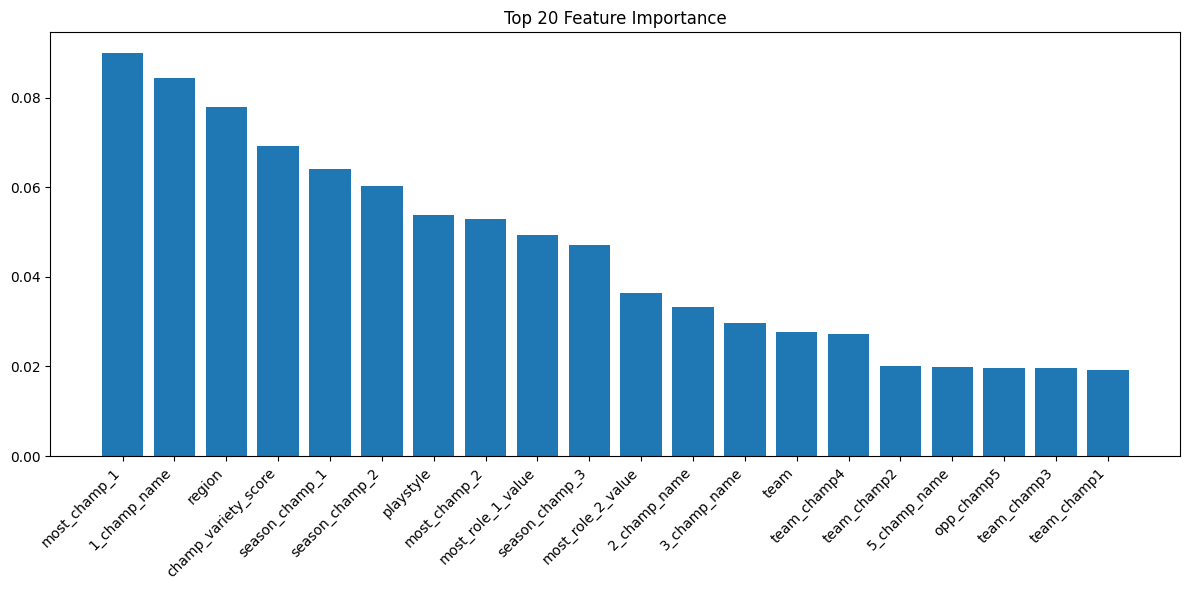

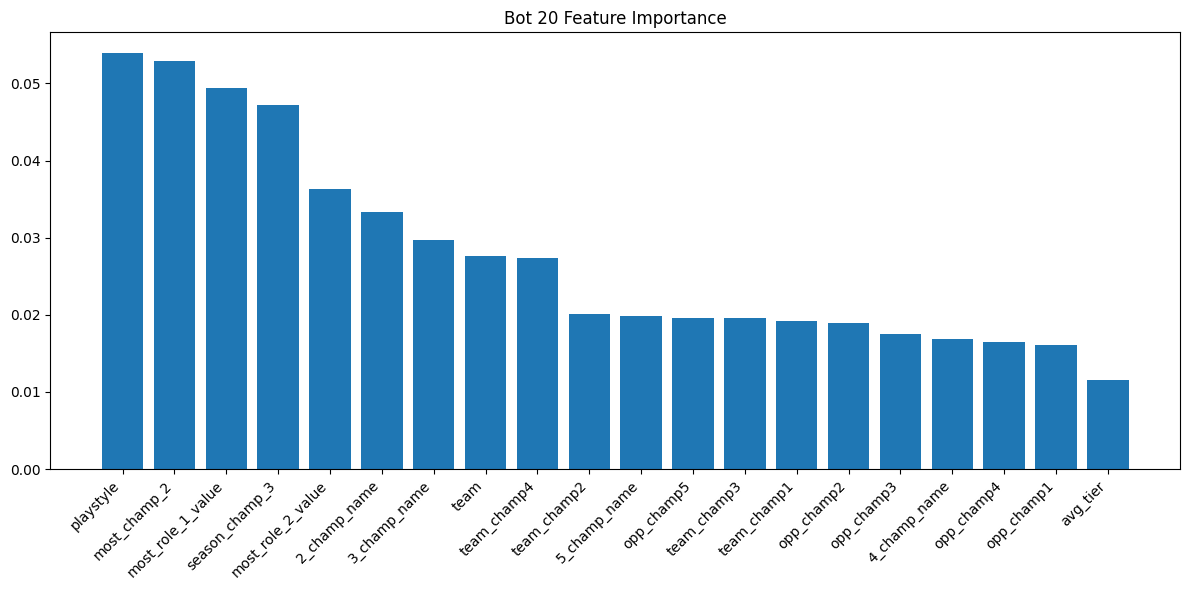

In [36]:
# Feature Importance Analysis
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20))

print("\nTop 20 Least Important Features:")
print(feature_importance.tail(20))

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.bar(feature_importance.head(20)['feature'], feature_importance.head(20)['importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Feature Importance')
plt.tight_layout()
plt.show()

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.bar(feature_importance.tail(20)['feature'], feature_importance.tail(20)['importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Bot 20 Feature Importance')
plt.tight_layout()
plt.show()

Class Distribution:
19     258
114    244
113    236
26     167
8      164
      ... 
123      8
91       8
49       8
90       8
126      8
Name: count, Length: 131, dtype: int64

Imbalance Ratio: 32.25


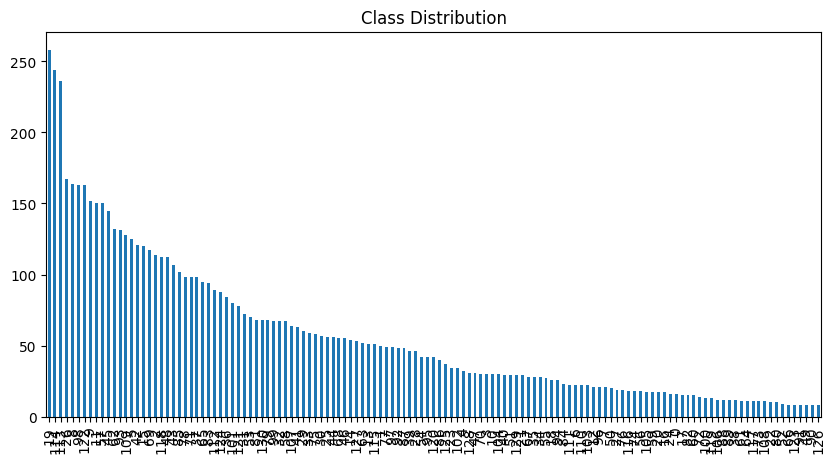

Class Distribution:
19     32
113    30
26     27
8      25
114    25
       ..
88      1
52      1
123     1
50      1
49      1
Name: count, Length: 129, dtype: int64

Imbalance Ratio: 32.0


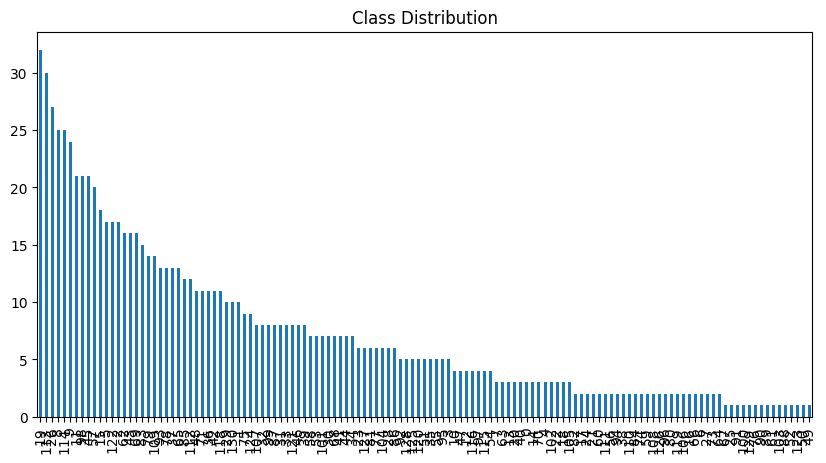

In [38]:
def analyze_class_distribution(y):
    distribution = pd.Series(y).value_counts()
    print("Class Distribution:")
    print(distribution)
    print("\nImbalance Ratio:", 
          distribution.max() / distribution.min())
    
    plt.figure(figsize=(10, 5))
    distribution.plot(kind='bar')
    plt.title('Class Distribution')
    plt.show()
    
    return distribution

# Check distribution
train_dist = analyze_class_distribution(y_train)
val_dist = analyze_class_distribution(y_val)

In [39]:
def analyze_predictability(X, y):
    # Check feature-target correlations
    correlations = []
    for col in X.columns:
        if X[col].dtype in ['int64', 'float64']:
            corr = np.corrcoef(X[col], y)[0,1]
            correlations.append((col, abs(corr)))
    
    # Sort by correlation strength
    correlations.sort(key=lambda x: x[1], reverse=True)
    
    print("Top 10 predictive features:")
    for col, corr in correlations[:10]:
        print(f"{col}: {corr:.3f}")
        
    return correlations

# Run predictability analysis
feature_predictability = analyze_predictability(X_train, y_train)

Top 10 predictive features:
most_champ_1: 0.508
team_champ3: 0.049
team_champ4: 0.041
team_champ2: 0.038
region: 0.036
most_champ_2: nan
season_champ_1: nan
season_champ_2: nan
season_champ_3: nan
1_champ_name: 0.391


In [40]:
# Check for missing values
def check_missing(df):
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    return pd.DataFrame({
        'Missing Count': missing,
        'Missing Percent': missing_pct
    }).sort_values('Missing Count', ascending=False)

missing_stats = check_missing(X_train)
print("Features with missing values:")
print(missing_stats[missing_stats['Missing Count'] > 0])

Features with missing values:
                Missing Count  Missing Percent
season_champ_3            267         3.580528
most_champ_2              202         2.708864
season_champ_2            158         2.118815
season_champ_1            143         1.917661


In [41]:
# Check data types
def check_datatypes(df):
    return pd.DataFrame({
        'dtype': df.dtypes,
        'unique_values': df.nunique()
    })

dtype_info = check_datatypes(X_train)
print("Feature data types:")
print(dtype_info)

Feature data types:
                       dtype  unique_values
region                 int64              4
team                   int64              2
avg_tier               int64              3
team_champ1            int64            140
team_champ2            int64            146
team_champ3            int64            133
team_champ4            int64            123
opp_champ1             int64            137
opp_champ2             int64             73
opp_champ3             int64            132
opp_champ4             int64            105
opp_champ5             int64             87
most_champ_1           int64            125
most_champ_2         float64            116
most_role_1_value    float64             15
most_role_2_value    float64             11
season_champ_1       float64            117
season_champ_2       float64            117
season_champ_3       float64            118
champ_variety_score    int64              6
playstyle              int32              6
1_champ_name

In [42]:
# Model evaluation
test_accuracy = xgb_classifier.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.4234


In [44]:
def predict_top_3_with_confidence(model, X, y_true, label_encoder):
    """
    Predict top 3 champions with confidence scores and compare with true label
    Returns a DataFrame with true champion, predicted champions and their confidence scores
    """
    # Get probabilities
    proba = model.predict_proba(X)
    
    # Get top 3 indices and probabilities
    top_3_idx = np.argsort(proba, axis=1)[:, -3:][:, ::-1]
    top_3_proba = np.take_along_axis(proba, top_3_idx, axis=1)
    
    # Initialize results DataFrame
    results = pd.DataFrame()
    
    # Add true champion
    results['True_Champion'] = label_encoder.inverse_transform(y_true)
    
    # Process each rank separately
    for i in range(3):
        # Convert indices to champion names one rank at a time
        champions = label_encoder.inverse_transform(top_3_idx[:, i])
        probabilities = top_3_proba[:, i]
        
        # Add to results
        results[f'Rank_{i+1}_Champion'] = champions
        results[f'Rank_{i+1}_Confidence'] = probabilities.round(4)
    
    # Add whether top prediction was correct
    results['Correct_Prediction'] = results['True_Champion'] == results['Rank_1_Champion']
    
    return results

In [45]:
test_predictions = predict_top_3_with_confidence(xgb_classifier, X_test.head(), y_test[:5], label_encoder)
print(test_predictions)

   True_Champion  Rank_1_Champion  Rank_1_Confidence  Rank_2_Champion  \
0             76               15             0.3365               83   
1            151               25             0.0423               37   
2            160              160             0.0657               22   
3            124               16             0.2320              124   
4            160              160             0.0817              159   

   Rank_2_Confidence  Rank_3_Champion  Rank_3_Confidence  Correct_Prediction  
0             0.0164              127             0.0155               False  
1             0.0375                2             0.0191               False  
2             0.0553              159             0.0356                True  
3             0.0280               51             0.0266               False  
4             0.0345               22             0.0194                True  


In [46]:
# Add some statistics
print("\nPrediction Statistics:")
print(f"Correct top predictions: {test_predictions['Correct_Prediction'].sum()} out of {len(test_predictions)}")
print(f"Accuracy: {test_predictions['Correct_Prediction'].mean():.2%}")

# Check if true champion appears in top 3
test_predictions['In_Top_3'] = test_predictions.apply(
    lambda row: row['True_Champion'] in [
        row['Rank_1_Champion'], 
        row['Rank_2_Champion'], 
        row['Rank_3_Champion']
    ], 
    axis=1
)

print(f"True champion in top 3: {test_predictions['In_Top_3'].sum()} out of {len(test_predictions)}")
print(f"Top 3 accuracy: {test_predictions['In_Top_3'].mean():.2%}")


Prediction Statistics:
Correct top predictions: 2 out of 5
Accuracy: 40.00%
True champion in top 3: 3 out of 5
Top 3 accuracy: 60.00%



Confidence Analysis:
Average confidence when correct: 0.0737
Average confidence when incorrect: 0.2036


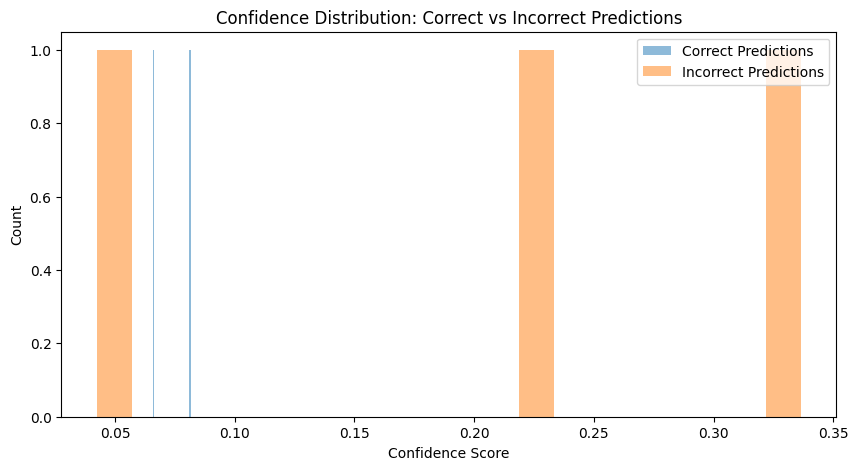

In [47]:
correct_conf = test_predictions[test_predictions['Correct_Prediction']]['Rank_1_Confidence']
incorrect_conf = test_predictions[~test_predictions['Correct_Prediction']]['Rank_1_Confidence']

if len(correct_conf) > 0 and len(incorrect_conf) > 0:
    print("\nConfidence Analysis:")
    print(f"Average confidence when correct: {correct_conf.mean():.4f}")
    print(f"Average confidence when incorrect: {incorrect_conf.mean():.4f}")

# Visualize confidence distribution for correct vs incorrect predictions
plt.figure(figsize=(10, 5))
plt.hist(correct_conf, alpha=0.5, label='Correct Predictions', bins=20)
plt.hist(incorrect_conf, alpha=0.5, label='Incorrect Predictions', bins=20)
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.title('Confidence Distribution: Correct vs Incorrect Predictions')
plt.legend()
plt.show()

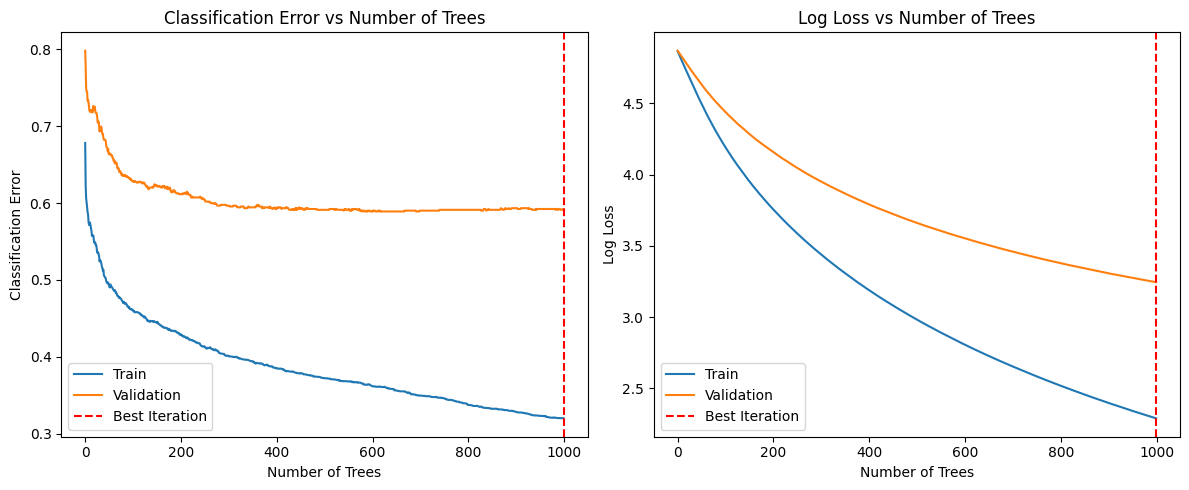

In [48]:
# Plot learning curves
results = xgb_classifier.evals_result()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(results['validation_0']['merror'], label='Train')
plt.plot(results['validation_1']['merror'], label='Validation')
plt.axvline(x=best_iteration, color='r', linestyle='--', label='Best Iteration')
plt.title('Classification Error vs Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Classification Error')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results['validation_0']['mlogloss'], label='Train')
plt.plot(results['validation_1']['mlogloss'], label='Validation')
plt.axvline(x=best_iteration, color='r', linestyle='--', label='Best Iteration')
plt.title('Log Loss vs Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Log Loss')
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\marth\AppData\Local\Temp\ipykernel_30088\2025323509.py:118: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bp = plt.boxplot([group['f1_score'] for name, group in performance_df.groupby('occurrence_bin')],
C:\Users\marth\AppData\Local\Temp\ipykernel_30088\2025323509.py:118: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot([group['f1_score'] for name, group in performance_df.groupby('occurrence_bin')],
C:\Users\marth\AppData\Local\Temp\ipykernel_30088\2025323509.py:128: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to ado

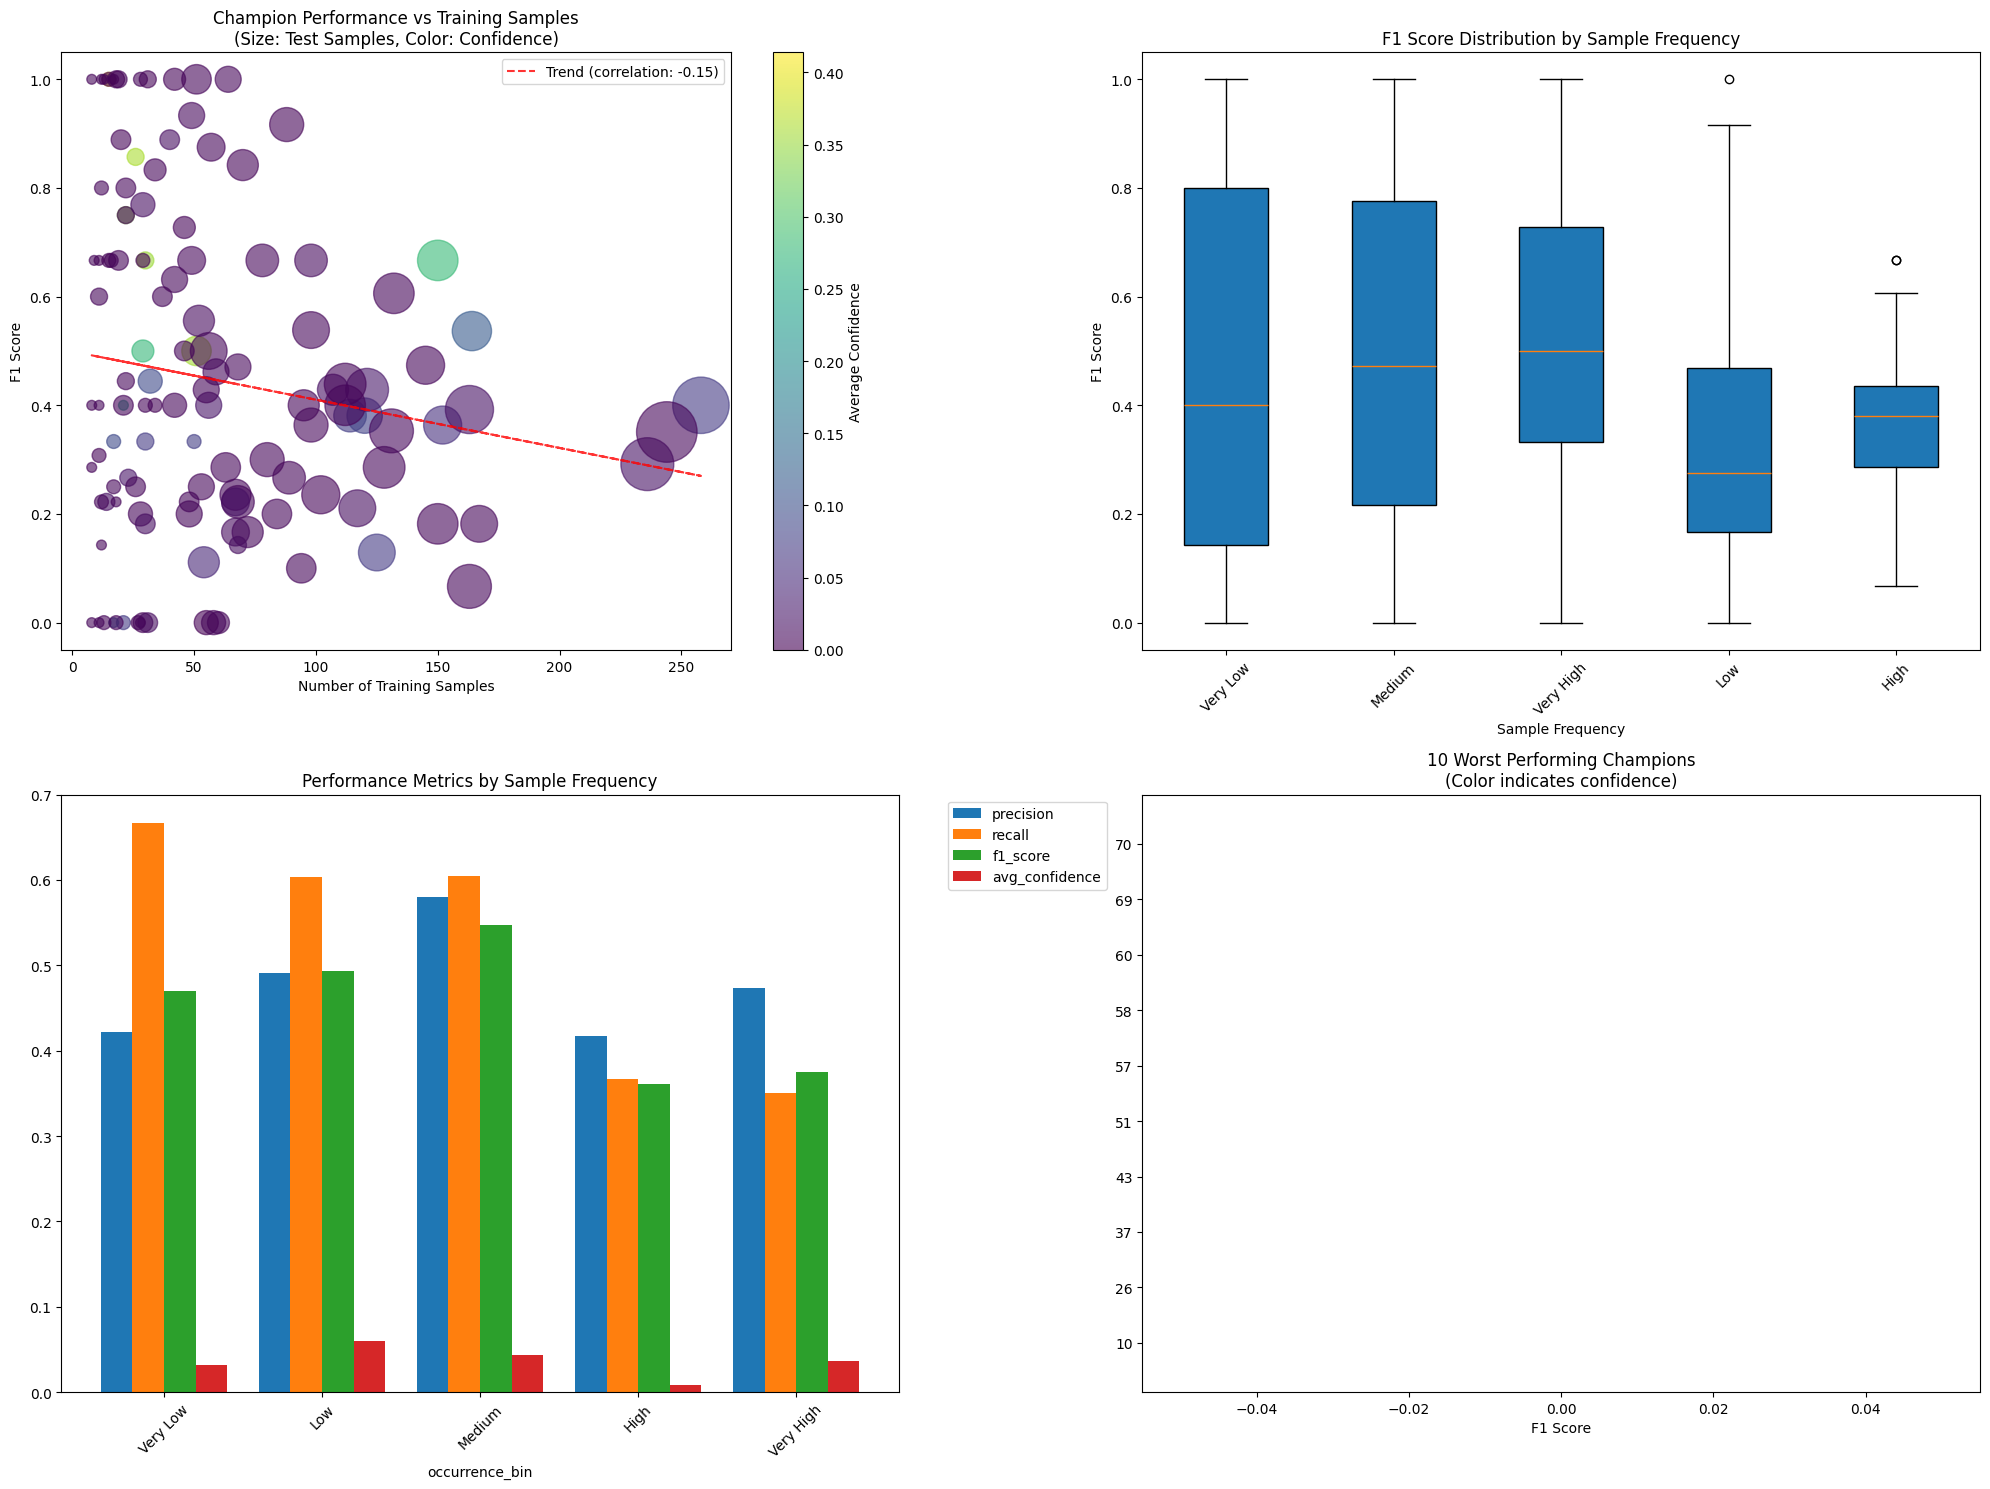


Performance Summary by Sample Frequency:
               training_samples          f1_score                       \
                           mean min  max     mean    std    min    max   
occurrence_bin                                                           
Very Low                 12.241   8   17    0.470  0.385  0.000  1.000   
Low                      23.542  18   29    0.493  0.357  0.000  1.000   
Medium                   41.120  30   53    0.547  0.285  0.000  1.000   
High                     68.923  54   95    0.361  0.290  0.000  1.000   
Very High               142.577  98  258    0.375  0.154  0.067  0.667   

               precision recall avg_confidence  
                    mean   mean           mean  
occurrence_bin                                  
Very Low           0.422  0.667          0.032  
Low                0.491  0.603          0.061  
Medium             0.580  0.604          0.044  
High               0.417  0.367          0.009  
Very High          0.4

C:\Users\marth\AppData\Local\Temp\ipykernel_30088\2025323509.py:149: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = performance_df.groupby('occurrence_bin').agg({
C:\Users\marth\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


In [49]:
def analyze_champion_performance(y_true, y_pred, y_prob, train_counts):
    """
    Analyze performance metrics for each champion.
    
    Parameters:
    -----------
    y_true : array-like
        True champion labels
    y_pred : array-like
        Predicted champion labels
    y_prob : array-like
        Prediction probabilities for each class
    train_counts : pd.Series
        Number of training samples for each champion
    
    Returns:
    --------
    pd.DataFrame
        DataFrame containing performance metrics for each champion
    """
    
    # Initialize results dictionary
    results = {
        'champion': [],
        'training_samples': [],
        'test_samples': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'avg_confidence': []
    }
    
    # Get unique champions
    unique_champions = np.unique(np.concatenate([y_true, y_pred]))
    
    # Calculate metrics for each champion
    for champion in unique_champions:
        # True positives and other metrics
        true_mask = (y_true == champion)
        pred_mask = (y_pred == champion)
        
        # Number of samples
        test_samples = np.sum(true_mask)
        training_samples = train_counts.get(champion, 0)
        
        # Calculate metrics
        tp = np.sum(true_mask & pred_mask)
        fp = np.sum(pred_mask) - tp
        fn = np.sum(true_mask) - tp
        
        # Precision, recall, and F1
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        # Calculate average confidence for correct predictions
        champion_idx = np.where(y_pred == champion)[0]
        avg_confidence = np.mean(y_prob[champion_idx, np.where(unique_champions == champion)[0]]) if len(champion_idx) > 0 else 0
        
        # Store results
        results['champion'].append(champion)
        results['training_samples'].append(training_samples)
        results['test_samples'].append(test_samples)
        results['precision'].append(precision)
        results['recall'].append(recall)
        results['f1_score'].append(f1)
        results['avg_confidence'].append(avg_confidence)
    
    # Convert to DataFrame
    performance_df = pd.DataFrame(results)
    
    return performance_df
    
# Get counts and predictions
train_champion_counts = pd.Series(label_encoder.inverse_transform(y_train)).value_counts()
y_pred = xgb_classifier.predict(X_test)
y_prob = xgb_classifier.predict_proba(X_test)
y_test_names = label_encoder.inverse_transform(y_test)
y_pred_names = label_encoder.inverse_transform(y_pred)

# Calculate performance metrics
performance_df = analyze_champion_performance(y_test_names, y_pred_names, y_prob, train_champion_counts)

# Add occurrence bins
performance_df['occurrence_bin'] = pd.qcut(performance_df['training_samples'], 
                                         q=5, 
                                         labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Create enhanced visualizations
fig = plt.figure(figsize=(20, 15))

# 1. Scatter plot with size based on test samples
plt.subplot(2, 2, 1)
scatter = plt.scatter(performance_df['training_samples'], 
                     performance_df['f1_score'],
                     s=performance_df['test_samples']*50,
                     alpha=0.6,
                     c=performance_df['avg_confidence'],
                     cmap='viridis')
plt.colorbar(scatter, label='Average Confidence')

# Add trend line
z = np.polyfit(performance_df['training_samples'], performance_df['f1_score'], 1)
p = np.poly1d(z)
plt.plot(performance_df['training_samples'], 
         p(performance_df['training_samples']), 
         "r--", 
         alpha=0.8,
         label=f'Trend (correlation: {performance_df["training_samples"].corr(performance_df["f1_score"]):.2f})')

plt.xlabel('Number of Training Samples')
plt.ylabel('F1 Score')
plt.title('Champion Performance vs Training Samples\n(Size: Test Samples, Color: Confidence)')
plt.legend()

# 2. Box plot
plt.subplot(2, 2, 2)
bp = plt.boxplot([group['f1_score'] for name, group in performance_df.groupby('occurrence_bin')],
                 labels=performance_df['occurrence_bin'].unique(),
                 patch_artist=True)
plt.xticks(rotation=45)
plt.xlabel('Sample Frequency')
plt.ylabel('F1 Score')
plt.title('F1 Score Distribution by Sample Frequency')

# 3. Performance metrics comparison
plt.subplot(2, 2, 3)
metrics_by_bin = performance_df.groupby('occurrence_bin')[['precision', 'recall', 'f1_score', 'avg_confidence']].mean()
metrics_by_bin.plot(kind='bar', width=0.8, ax=plt.gca())
plt.title('Performance Metrics by Sample Frequency')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 4. Top 10 worst performers with confidence
plt.subplot(2, 2, 4)
worst_performers = performance_df.nsmallest(10, 'f1_score')
bars = plt.barh(range(len(worst_performers)), 
                worst_performers['f1_score'],
                color=plt.cm.RdYlGn(worst_performers['avg_confidence']))
plt.yticks(range(len(worst_performers)), worst_performers['champion'])
plt.xlabel('F1 Score')
plt.title('10 Worst Performing Champions\n(Color indicates confidence)')

plt.tight_layout()
plt.show()

# Print analyses
print("\nPerformance Summary by Sample Frequency:")
summary = performance_df.groupby('occurrence_bin').agg({
    'training_samples': ['mean', 'min', 'max'],
    'f1_score': ['mean', 'std', 'min', 'max'],
    'precision': 'mean',
    'recall': 'mean',
    'avg_confidence': 'mean'
}).round(3)
print(summary)

print("\nDetailed Analysis of Worst Performing Champions:")
print(worst_performers[['champion', 'training_samples', 'test_samples', 
                       'precision', 'recall', 'f1_score', 'avg_confidence']].round(3))

print("\nChampions with High Confidence but Low Performance (Overconfident):")
overconfident = performance_df[
    (performance_df['avg_confidence'] > performance_df['avg_confidence'].median()) &
    (performance_df['f1_score'] < performance_df['f1_score'].median())
].sort_values('avg_confidence', ascending=False)
print(overconfident[['champion', 'training_samples', 'f1_score', 'avg_confidence']].head())

print("\nCorrelation Matrix:")
correlation_matrix = performance_df[['training_samples', 'f1_score', 'avg_confidence']].corr()
print(correlation_matrix.round(3))

# Additional Analysis: Performance vs Sample Size Ratio
performance_df['train_test_ratio'] = performance_df['training_samples'] / performance_df['test_samples']
print("\nPerformance vs Train/Test Ratio Correlation:", 
      performance_df['train_test_ratio'].corr(performance_df['f1_score']).round(3))

# Identify champions needing attention
threshold_samples = performance_df['training_samples'].median()
threshold_f1 = performance_df['f1_score'].median()

needs_attention = performance_df[
    (performance_df['training_samples'] < threshold_samples) &
    (performance_df['f1_score'] < threshold_f1)
].sort_values('f1_score')

print("\nRecommendations for Improvement:")
print(f"Number of champions needing attention: {len(needs_attention)}")
print("\nPriority Champions for Data Collection:")
print(needs_attention[['champion', 'training_samples', 'f1_score', 'avg_confidence']].head())

# Save analysis results
analysis_results = {
    'worst_performers': worst_performers['champion'].tolist(),
    'overconfident_champions': overconfident['champion'].tolist(),
    'needs_attention': needs_attention['champion'].tolist(),
    'correlation_stats': correlation_matrix.to_dict()
}

print("\nSummary Statistics:")
print(f"Average F1 Score: {performance_df['f1_score'].mean():.3f}")
print(f"Median F1 Score: {performance_df['f1_score'].median():.3f}")
print(f"F1 Score Standard Deviation: {performance_df['f1_score'].std():.3f}")

## <span style='color:#ff5f27'>🗄 Save Model</span>

### <span style="color:#ff5f27;">⚙️ Model Schema</span>

In [54]:
import joblib
# Save the model and label encoder
save_dir = os.path.join(current_dir, 'model')
filepath = os.path.join(save_dir, 'champion_predictor.json')
filepath2 = os.path.join(save_dir, 'label_encoder.joblib')
        
xgb_classifier.save_model(filepath)
joblib.dump(label_encoder, filepath2)

['label_encoder.joblib']